# Interactive Visualization Notebook

This notebook will cover everything outside of the dashboard.

In [15]:
import pandas as pd
import plotly.express as px
import time
import json
import tracemalloc
from tqdm import tqdm
import os

In [2]:
data = pd.read_csv('./data/ebd_SE_relSep-2024/ebd_SE_relSep-2024.txt', sep='\t', low_memory=False)
data.head()

,GLOBAL UNIQUE IDENTIFIER,LAST EDITED DATE,TAXONOMIC ORDER,CATEGORY,TAXON CONCEPT ID,COMMON NAME,SCIENTIFIC NAME,SUBSPECIES COMMON NAME,SUBSPECIES SCIENTIFIC NAME,EXOTIC CODE,...,NUMBER OBSERVERS,ALL SPECIES REPORTED,GROUP IDENTIFIER,HAS MEDIA,APPROVED,REVIEWED,REASON,TRIP COMMENTS,SPECIES COMMENTS,Unnamed: 49
0,URN:CornellLabOfOrnithology:EBIRD:OBS2485965178,2024-09-24 08:36:37.554738,11549,species,avibase-EDB4BBA6,Black Woodpecker,Dryocopus martius,NaN,NaN,NaN,...,2.0,0,NaN,0,1,0,NaN,NaN,NaN,NaN
1,URN:CornellLabOfOrnithology:EBIRD:OBS2485965182,2024-09-24 08:36:37.554738,11439,species,avibase-A01014FF,Eurasian Green Woodpecker,Picus viridis,NaN,NaN,NaN,...,2.0,0,NaN,0,1,0,NaN,NaN,NaN,NaN
2,URN:CornellLabOfOrnithology:EBIRD:OBS2485965184,2024-09-24 08:36:37.554738,27987,species,avibase-88BB4F2A,Eurasian Blackbird,Turdus merula,NaN,NaN,NaN,...,2.0,0,NaN,0,1,0,NaN,NaN,NaN,NaN
3,URN:CornellLabOfOrnithology:EBIRD:OBS2485965176,2024-09-24 08:36:37.554738,20948,species,avibase-D8D10F2C,Eurasian Jay,Garrulus glandarius,NaN,NaN,NaN,...,2.0,0,NaN,0,1,0,NaN,NaN,NaN,NaN
4,URN:CornellLabOfOrnithology:EBIRD:OBS2485965183,2024-09-24 08:36:37.554738,28756,species,avibase-C809B2B9,European Robin,Erithacus rubecula,NaN,NaN,NaN,...,2.0,0,NaN,0,1,0,NaN,NaN,NaN,NaN


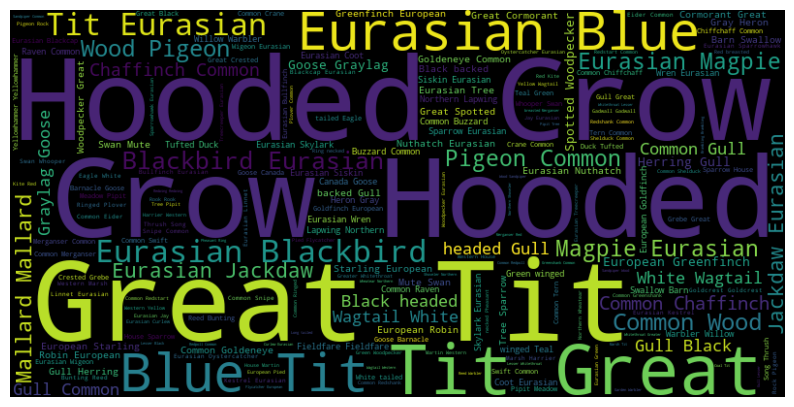

In [3]:
# plot wordcloud of species comments
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(data['COMMON NAME'].dropna())
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [4]:
len(data)

3356714

## LO1: Performance

In [10]:
RESULTS_EXPORT_PATH = './results'
os.makedirs('results', exist_ok=True)

### Experiment 1: Performance of Geospatial Plotting

In this first experiment I am looking at the impact the number of data points have on space and time complexity in a geospatial scatter map. For that the entire data set of `3356714` observations will be plotted over 10 different-sized splits on a geospatial map (using Mapbox inside Plotly Express). First `1/10` of the data set will be loaded into memory, then `2/10`, `3/10` and so on until all `3356714` are plotted.

The results get written into `/results/map_loading_metrics.json`.

In [12]:
performance_data = {}

for i in tqdm(range(1, 11), desc="Running Performance Tests"):
    fraction = i / 10
    subset = data.sample(frac=fraction, random_state=42)

    tracemalloc.start()

    start_time = time.time()

    fig = px.scatter_mapbox(
        subset,
        lat="LATITUDE",
        lon="LONGITUDE",
        hover_name="COMMON NAME",
        hover_data=["SCIENTIFIC NAME", "OBSERVATION COUNT"],
        color_discrete_sequence=["blue"],
        zoom=5,
        height=600
    )

    fig_html = fig.to_html()

    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    performance_data[f"{i}/10"] = {
        "time_taken_seconds": end_time - start_time,
        "memory_used_kb": current / 1024,
        "peak_memory_used_kb": peak / 1024,
        "data_points_count": len(subset)
    }

    print(f"Fraction {i}/10 - Time: {end_time - start_time:.2f}s, "
          f"Memory: {current / 1024:.2f} KB, Peak Memory: {peak / 1024:.2f} KB")

with open(f"{RESULTS_EXPORT_PATH}/map_loading_metrics.json", "w") as json_file:
    json.dump(performance_data, json_file, indent=4)

print("All performance metrics saved to map_loading_metrics.json")


Running Performance Tests:  10%|█         | 1/10 [00:06<01:00,  6.69s/it]

Fraction 1/10 - Time: 5.53s, Memory: 76952.71 KB, Peak Memory: 216517.58 KB


Running Performance Tests:  20%|██        | 2/10 [00:19<01:21, 10.13s/it]

Fraction 2/10 - Time: 11.56s, Memory: 144969.21 KB, Peak Memory: 401804.84 KB


Running Performance Tests:  30%|███       | 3/10 [00:38<01:39, 14.16s/it]

Fraction 3/10 - Time: 17.01s, Memory: 212709.29 KB, Peak Memory: 586778.17 KB


Running Performance Tests:  40%|████      | 4/10 [01:02<01:48, 18.00s/it]

Fraction 4/10 - Time: 22.03s, Memory: 280586.00 KB, Peak Memory: 771898.03 KB


Running Performance Tests:  50%|█████     | 5/10 [01:33<01:54, 22.98s/it]

Fraction 5/10 - Time: 29.20s, Memory: 348457.06 KB, Peak Memory: 957013.51 KB


Running Performance Tests:  60%|██████    | 6/10 [02:11<01:51, 27.86s/it]

Fraction 6/10 - Time: 34.35s, Memory: 416328.84 KB, Peak Memory: 1142100.29 KB


Running Performance Tests:  70%|███████   | 7/10 [02:52<01:37, 32.35s/it]

Fraction 7/10 - Time: 38.36s, Memory: 484200.76 KB, Peak Memory: 1327239.12 KB


Running Performance Tests:  80%|████████  | 8/10 [03:42<01:15, 37.87s/it]

Fraction 8/10 - Time: 45.95s, Memory: 552088.05 KB, Peak Memory: 1512361.43 KB


Running Performance Tests:  90%|█████████ | 9/10 [04:37<00:43, 43.21s/it]

Fraction 9/10 - Time: 50.67s, Memory: 501922.60 KB, Peak Memory: 1579439.05 KB


Running Performance Tests: 100%|██████████| 10/10 [05:37<00:00, 33.74s/it]

Fraction 10/10 - Time: 55.35s, Memory: 687839.12 KB, Peak Memory: 1882592.17 KB
All performance metrics saved to map_loading_metrics.json


### Experiment 2: Matplotlib, Plotly and Seaborn

In the second experiment I look at different plotting libraries that can be used. The most common ones are `matplotlib`, `plotly` and `seaborn`.

Here, the top 10 most frequent bird species get plotted into a bar plot, showing their frequency in the entire data set.

The results get written into `/results/barplot_performance_metrics.json`.

In [17]:
top_10_birds = data['COMMON NAME'].value_counts().head(10)
top_10_birds

COMMON NAME
Hooded Crow           84900
Great Tit             81196
Eurasian Blue Tit     74182
Eurasian Blackbird    72655
Common Wood-Pigeon    69061
Mallard               67045
Eurasian Magpie       66051
Eurasian Jackdaw      59620
Common Chaffinch      57488
White Wagtail         53960
Name: count, dtype: int64

In [16]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

def log_performance(library_name, start_time, end_time, current, peak, data_count, metrics):
    metrics[library_name] = {
        "time_taken_seconds": end_time - start_time,
        "memory_used_kb": current / 1024,
        "peak_memory_used_kb": peak / 1024,
        "data_points_count": data_count
    }

performance_data = {}

def plot_matplotlib():
    plt.figure(figsize=(10, 6))
    plt.bar(top_10_birds.index, top_10_birds.values, color='blue')
    plt.title('Top 10 Bird Species in eBird Dataset (Matplotlib)')
    plt.xlabel('Bird Species')
    plt.ylabel('Observation Count')
    plt.close()

def plot_plotly():
    fig = px.bar(
        x=top_10_birds.index,
        y=top_10_birds.values,
        labels={"x": "Bird Species", "y": "Observation Count"},
        title="Top 10 Bird Species in eBird Dataset (Plotly)"
    )
    fig.write_html("plotly_plot.html")

def plot_seaborn():
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_10_birds.index, y=top_10_birds.values, color="blue")
    plt.title("Top 10 Bird Species in eBird Dataset (Seaborn)")
    plt.xlabel("Bird Species")
    plt.ylabel("Observation Count")
    plt.close()

libraries = {
    "matplotlib": plot_matplotlib,
    "plotly": plot_plotly,
    "seaborn": plot_seaborn
}

for lib_name, plot_func in tqdm(libraries.items(), desc="Running Library Comparison"):
    tracemalloc.start()
    
    start_time = time.time()
    plot_func()
    end_time = time.time()
    
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    log_performance(lib_name, start_time, end_time, current, peak, len(top_10_birds), performance_data)
    
    print(f"{lib_name} - Time: {end_time - start_time:.2f}s, "
          f"Memory: {current / 1024:.2f} KB, Peak Memory: {peak / 1024:.2f} KB")

with open(f"{RESULTS_EXPORT_PATH}/barplot_performance_metrics.json", "w") as json_file:
    json.dump(performance_data, json_file, indent=4)

print("Performance metrics saved to results/barplot_performance_metrics.json")


Running Library Comparison:   0%|          | 0/3 [00:00<?, ?it/s]

matplotlib - Time: 0.07s, Memory: 423.82 KB, Peak Memory: 434.39 KB
plotly - Time: 0.19s, Memory: 348.87 KB, Peak Memory: 31581.56 KB


Running Library Comparison: 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]

seaborn - Time: 0.23s, Memory: 929.56 KB, Peak Memory: 933.46 KB
Performance metrics saved to results/barplot_performance_metrics.json
